In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [2]:
# Labels for charts, tables
models = {'electra-base-discriminator': 'ELECTRA', 'google/electra-base-discriminator': 'ELECTRA', 'roberta-base': 'RoBERTa', 'bert-base-uncased': 'BERT', 'distilbert-base-uncased': 'DistilBERT', 'elmo':'ELMo'}
# datasets = {'kaggle_1000': 'Fake and Real News', 'fake_real_1000': 'Fake or Real News', 'liar_1000': 'Liar'}

### Visualization on **validation** set

In [ ]:
MODE = 'argumentation-based'
if MODE == 'argumentation-based':
    TOOL = 'margot'
    ELEMENT = 'structure'

    input_path = f"models/{MODE}/{TOOL}/{ELEMENT}/training/"
    output_path = f'pipeline/{MODE}/results/figures/{TOOL}_{ELEMENT}.png'
else:
    input_path = f"models/{MODE}/training/"
    output_path = f'pipeline/{MODE}/results/figures/baseline.png'

In [203]:
# Plot results baseline

res = defaultdict(dict)
x_values, y_values, hue_values = [], [], []

for root, dirs, files in os.walk(input_path):
    mets = []
    for file in files:

        # Look for trainer_state.json files for all models except for ELMo 
        if file == 'trainer_state.json':
            # PREPARE FOR TABLE
            metrics = {}

            model_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
            dataset = os.path.basename(os.path.dirname(root))
            trainer_state = os.path.join(root, file)

            with open(trainer_state) as f:
                data = json.load(f)

            f1 = data["log_history"][1]["eval_f1"]
            accuracy = data["log_history"][1]["eval_accuracy"]
            recall = data["log_history"][1]["eval_recall"]
            precision = data["log_history"][1]["eval_precision"]

            metrics['F1'] = "{:.2f}".format(f1)
            metrics['Accuracy'] = "{:.2f}".format(accuracy)
            metrics['Recall'] = "{:.2f}".format(recall)
            metrics['Precision'] = "{:.2f}".format(precision)

            res[models[model_name]][datasets[dataset]] = metrics

            # PREPARE FOR CHART 
            x_values.append(models[model_name])
            hue_values.append(datasets[dataset])
            y_values.append(float("{:.2f}".format(f1)))

        # Prepare doing the same for ELMo
        if 'elmo' in os.path.dirname(root):
            if file.endswith('.json'):
                mets.append(file)    
    
    # All ELMo from here
    mets_sorted = sorted(mets, key=lambda x: int(x.split(".")[0][-1]), reverse=True) # Only keep best EPOCH

    if mets_sorted:
        metrics = {}
        model_name = os.path.basename(os.path.dirname(root))
        dataset = os.path.basename(root)
        best_metric = mets_sorted[0]
        best_mets_file = os.path.join(root, best_metric)

        with open(best_mets_file) as f:
            data = json.load(f)
        
        f1 = data["best_validation_f1"]
        accuracy = data["best_validation_accuracy"]
        precision = data["best_validation_precision"]
        recall = data["best_validation_recall"]

        metrics['Accuracy'] = "{:.2f}".format(accuracy)
        metrics['Precision'] = "{:.2f}".format(precision)
        metrics['Recall'] = "{:.2f}".format(recall)
        metrics['F1'] = "{:.2f}".format(f1)

        
        res[models[model_name]][datasets[dataset]] = metrics

        # PREPARE FOR CHART
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])   
        y_values.append(float("{:.2f}".format(f1)))

In [204]:
res

defaultdict(dict,
            {'ELMo': {'Fake and Real News': {'Accuracy': '0.96',
               'Precision': '0.93',
               'Recall': '1.00',
               'F1': '0.96'},
              'Fake or Real News': {'Accuracy': '0.78',
               'Precision': '0.68',
               'Recall': '0.72',
               'F1': '0.70'},
              'Liar': {'Accuracy': '0.62',
               'Precision': '0.00',
               'Recall': '0.00',
               'F1': '0.00'}},
             'ELECTRA': {'Fake and Real News': {'F1': '0.93',
               'Accuracy': '0.92',
               'Recall': '1.00',
               'Precision': '0.86'},
              'Fake or Real News': {'F1': '0.76',
               'Accuracy': '0.78',
               'Recall': '0.94',
               'Precision': '0.63'},
              'Liar': {'F1': '0.77',
               'Accuracy': '0.62',
               'Recall': '1.00',
               'Precision': '0.62'}},
             'RoBERTa': {'Fake and Real News': {'F1': '

In [205]:
# F1 table only
index = res.keys()
values = []
cols = []

for model_name, d in res.items():
    tmp_cols = []

    for dataset, scores in d.items():
        for metric, score in scores.items():
            if metric == 'F1':
                values.append(score)
                tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df = df.T

df = df.reindex(index=['BERT', 'RoBERTa', 'DistilBERT', 'ELECTRA', 'ELMo'])

print(df.to_latex())

\begin{tabular}{llll}
\toprule
 & Fake and Real News & Fake or Real News & Liar \\
 & F1 & F1 & F1 \\
\midrule
BERT & 0.93 & 0.77 & 0.80 \\
RoBERTa & 0.00 & 0.67 & 0.96 \\
DistilBERT & 0.76 & 0.94 & 0.77 \\
ELECTRA & 0.70 & 0.98 & 0.77 \\
ELMo & 0.96 & 0.77 & 0.85 \\
\bottomrule
\end{tabular}



In [206]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores
reformed = []
for k, v in res.items():
    x = {(outerKey, innerKey): values for outerKey, innerDict in v.items() for innerKey, values in innerDict.items()}
    y = pd.DataFrame(x, index=[k])
    reformed.append(y)

df = pd.concat(reformed)
df = df.reindex(index=['BERT', 'RoBERTa', 'DistilBERT', 'ELECTRA', 'ELMo'])
df


Fake and Real News                        Fake or Real News  \
                     Accuracy Precision Recall    F1          Accuracy   
BERT                     0.94      0.89   1.00  0.94              0.88   
RoBERTa                  0.98      0.96   1.00  0.98              0.82   
DistilBERT               0.96      0.93   1.00  0.96              0.84   
ELECTRA                  0.92      0.86   1.00  0.93              0.78   
ELMo                     0.96      0.93   1.00  0.96              0.78   

                                      Liar                         
           Precision Recall    F1 Accuracy Precision Recall    F1  
BERT            0.77   0.94  0.85     0.62      0.62   1.00  0.77  
RoBERTa         1.00   0.50  0.67     0.62      0.62   1.00  0.77  
DistilBERT      0.73   0.89  0.80     0.62      0.62   1.00  0.77  
ELECTRA         0.63   0.94  0.76     0.62      0.62   1.00  0.77  
ELMo            0.68   0.72  0.70     0.62      0.00   0.00  0.00

In [207]:
# For thesis
print(df.to_latex())

\begin{tabular}{lllllllllllll}
\toprule
 & \multicolumn{4}{r}{Fake and Real News} & \multicolumn{4}{r}{Fake or Real News} & \multicolumn{4}{r}{Liar} \\
 & Accuracy & Precision & Recall & F1 & Accuracy & Precision & Recall & F1 & Accuracy & Precision & Recall & F1 \\
\midrule
BERT & 0.94 & 0.89 & 1.00 & 0.94 & 0.88 & 0.77 & 0.94 & 0.85 & 0.62 & 0.62 & 1.00 & 0.77 \\
RoBERTa & 0.98 & 0.96 & 1.00 & 0.98 & 0.82 & 1.00 & 0.50 & 0.67 & 0.62 & 0.62 & 1.00 & 0.77 \\
DistilBERT & 0.96 & 0.93 & 1.00 & 0.96 & 0.84 & 0.73 & 0.89 & 0.80 & 0.62 & 0.62 & 1.00 & 0.77 \\
ELECTRA & 0.92 & 0.86 & 1.00 & 0.93 & 0.78 & 0.63 & 0.94 & 0.76 & 0.62 & 0.62 & 1.00 & 0.77 \\
ELMo & 0.96 & 0.93 & 1.00 & 0.96 & 0.78 & 0.68 & 0.72 & 0.70 & 0.62 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



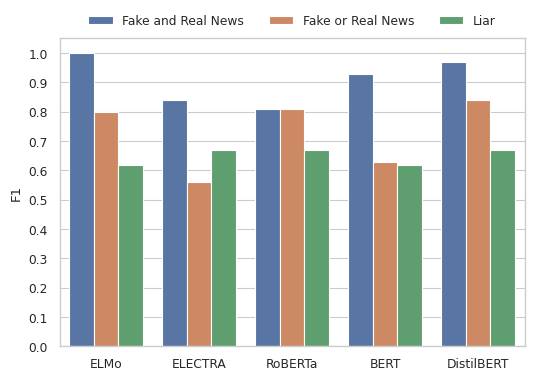

In [190]:
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig(f"{output_path}.png")

### Visualisation on **test** set

In [3]:
# Concat inference results ELMo with other models
path_to_json_results = "pipeline/text-based/results/json"

performance = {}
for file_name in os.listdir(path_to_json_results):
    path = os.path.join(path_to_json_results, file_name)
    if file_name != '.ipynb_checkpoints':
        with open(path) as f:
            json_results = json.load(f)
            performance.update(json_results)

In [4]:
performance

{'bert-base-uncased': {'accuracy': 0.7787810383747178,
  'precision': 0.8050847457627118,
  'recall': 0.7851239669421488,
  'f1': 0.794979079497908},
 'roberta-base': {'accuracy': 0.7652370203160271,
  'precision': 0.7225806451612903,
  'recall': 0.9256198347107438,
  'f1': 0.8115942028985507},
 'distilbert-base-uncased': {'accuracy': 0.7968397291196389,
  'precision': 0.7835820895522388,
  'recall': 0.8677685950413223,
  'f1': 0.8235294117647058},
 'google/electra-base-discriminator': {'accuracy': 0.7765237020316027,
  'precision': 0.7619047619047619,
  'recall': 0.859504132231405,
  'f1': 0.8077669902912621}}

In [35]:
# F1 table only
idx, values, cols = [], [], []

for model, scores in performance.items():
    for metric, score in scores.items():
        if metric == 'f1':
            idx.append(models[model])
            values.append(score)
            cols.append(('baseline', metric))

multi_columns = pd.MultiIndex.from_tuples([('baseline', 'f1')])
multi_columns

df = pd.DataFrame(values, index=idx, columns=multi_columns)
df

,baseline
,f1
BERT,0.794979
RoBERTa,0.811594
DistilBERT,0.823529
ELECTRA,0.807767


In [106]:
idx = list(performance.keys())

columns = [[('baseline', j) for j in performance[i]] for i in performance]

values = [[performance[i][j] for j in performance[i]] for i in performance]

multi_columns = pd.MultiIndex.from_tuples(columns[0])
reshaped_values = np.array(values)#.reshape(len(index), -1)  
df = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)

df

baseline                              
                                   accuracy precision    recall        f1
bert-base-uncased                  0.778781  0.805085  0.785124  0.794979
roberta-base                       0.765237  0.722581  0.925620  0.811594
distilbert-base-uncased            0.796840  0.783582  0.867769  0.823529
google/electra-base-discriminator  0.776524  0.761905  0.859504  0.807767

In [66]:
# F1 table only
idx, values, cols = [], [], []

for model, scores in performance.items():
    idx.append(models[model])

    # tmp = []
    for metric, score in scores.items():
        values.append(score)
        cols.append(('baseline pipelinne', metric))
    #cols.append(tmp)

# print(idx)
# cols = sum(cols, [])
multi_columns = pd.MultiIndex.from_tuples(cols)
print(multi_columns)

reshaped_values = np.array(values).reshape(len(index), -1)  
print(reshaped_values)

df = pd.DataFrame(np.random.rand(4,16), index=idx, columns=multi_columns)
df

MultiIndex([('baseline',  'accuracy'),
            ('baseline', 'precision'),
            ('baseline',    'recall'),
            ('baseline',        'f1'),
            ('baseline',  'accuracy'),
            ('baseline', 'precision'),
            ('baseline',    'recall'),
            ('baseline',        'f1'),
            ('baseline',  'accuracy'),
            ('baseline', 'precision'),
            ('baseline',    'recall'),
            ('baseline',        'f1'),
            ('baseline',  'accuracy'),
            ('baseline', 'precision'),
            ('baseline',    'recall'),
            ('baseline',        'f1')],
           )
[[0.77878104 0.80508475 0.78512397 0.79497908]
 [0.76523702 0.72258065 0.92561983 0.8115942 ]
 [0.79683973 0.78358209 0.8677686  0.82352941]
 [0.7765237  0.76190476 0.85950413 0.80776699]]


baseline                                                    \
            accuracy precision    recall        f1  accuracy precision   
BERT        0.105691  0.494902  0.008056  0.830907  0.110710  0.995179   
RoBERTa     0.106573  0.864214  0.813796  0.283192  0.344074  0.675058   
DistilBERT  0.054581  0.357781  0.853467  0.787206  0.462814  0.331824   
ELECTRA     0.760865  0.567576  0.326863  0.849436  0.281283  0.632588   

                                                                        \
              recall        f1  accuracy precision    recall        f1   
BERT        0.229874  0.878425  0.886084  0.180823  0.311020  0.607325   
RoBERTa     0.821837  0.074912  0.732794  0.130767  0.019714  0.059113   
DistilBERT  0.314442  0.404715  0.539282  0.529432  0.737259  0.540362   
ELECTRA     0.747194  0.839131  0.059506  0.969629  0.279770  0.365641   

                                                    
            accuracy precision    recall        f1  
BERT        0.814239  0.564384  0.946119  0.369405  
RoBERTa     0.328292  0.009937  0.508331  0.393422  
DistilBERT  0.474613  0.514514  0.190599  0.860671  
ELECTRA     0.708322  0.537486  0.675317  0.864158

In [8]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores

index = performance.keys()
values, cols = [], [] # For table

x_values, y_values, hue_values = [], [], [] # For chart

for dataset, scores in performance.items():
    for metric, score in scores.items():
        # Table
        values.append(score)
        tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# # Flatten columns
# cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# # Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

# # TABLE
df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df.T

NameError: name 'tmp_cols' is not defined

In [49]:
# For chart
x_values, y_values, hue_values = [], [], [] # For chart

for model_name, d in performance.items():
    for dataset, scores in d.items():
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])
        y_values.append(d[dataset]['f1'])

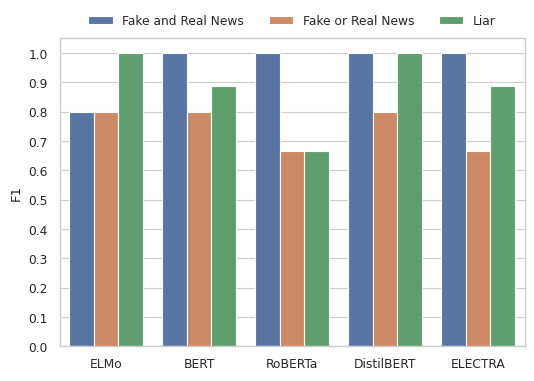

In [50]:
# Chart
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig(output_path)